In [1]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 91.0 MB/s eta 0:00:00


In [17]:
import rasterio
import numpy as np

# Define the tile size (adjust as needed)
tile_size = (512, 512)  # You can change this to a suitable tile size

# Open the two TIFF images
with rasterio.open('/content/landcover_colombian_amazon_2014.tif') as src1, rasterio.open('/content/landcover_colombian_amazon_2016.tif') as src2:
    # Check if images have the same dimensions
    if src1.shape != src2.shape:
        raise ValueError("Images must have the same dimensions.")

    # Read image metadata
    width, height = src1.width, src1.height
    count = src1.count  # Number of image bands

    # Create an output change map
    change_map = np.zeros((height, width), dtype=np.uint8)

    # Loop through tiles
    for x in range(0, width, tile_size[0]):
        for y in range(0, height, tile_size[1]):
            # Read tiles from both images
            window = rasterio.windows.Window(x, y, min(tile_size[0], width - x), min(tile_size[1], height - y))
            tile1 = src1.read(window=window)
            tile2 = src2.read(window=window)

            # Calculate the absolute difference between the two tiles
            difference = np.abs(tile1 - tile2)

            # Convert the difference to grayscale (if needed)
            gray_difference = np.mean(difference, axis=0)

            # Apply a threshold to create a binary tile change map
            threshold = 1  # Adjust this threshold as needed
            tile_change_map = (gray_difference > threshold).astype(np.uint8) * 255

            # Place the tile change map in the output change map
            change_map[y:y+window.height, x:x+window.width] = tile_change_map

cv2.imwrite('change_map.tif', change_map)


True

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


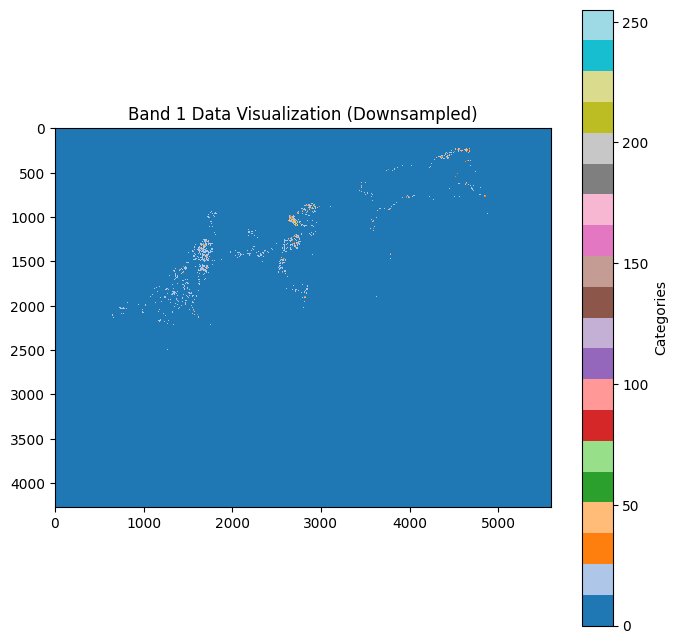

In [19]:
import matplotlib.pyplot as plt

# Display the change map
with rasterio.open('/content/change_map.tif') as src:
    # Read the data in Band 1
    band1_data = src.read(1)

    # Downsample the data (e.g., by a factor of 8)
    downsampled_data = band1_data[::8, ::8]

    # Create a color-mapped plot
    fig, ax = plt.subplots(figsize=(8, 8))  # Create a new figure and axes
    cmap = plt.get_cmap('tab20')
    im = ax.imshow(downsampled_data, cmap=cmap)

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, label='Categories')

    # Set the title
    ax.set_title('Band 1 Data Visualization (Downsampled)')

    # Display the plot
    plt.show()

In [20]:
import rasterio
import numpy as np

# Load the boolean change map
with rasterio.open('change_map.tif') as src:
    change_map = src.read(1)

# Calculate the total changed area in square meters
total_changed_area_sq_meters = np.sum(change_map)

# Convert the total changed area to square kilometers
total_changed_area_sq_km = total_changed_area_sq_meters / 1e6

print(f'Total changed area: {total_changed_area_sq_km} square kilometers')

Total changed area: 557.07708 square kilometers
